# Common Neighbor Rule in PyC Subgraph (Th=300)

In [1]:
import os
import random
from time import time
import pandas as pd
import numpy as np
import networkx as nx

from utils.utils import *
from utils.proximity import *
from utils.graph_creation import *
from utils.visualization import *
from utils.common_neighbor_rule import *

### 1. Create PyC Subgraph

In [2]:
pyc_synapses = pd.read_csv('data/synapses.csv')
pyc_soma = pd.read_csv('data/soma.csv')

In [3]:
# create the simple directed graph (no self-loops, no multi-edges)
# treat multiple synapses as one connection
pyc_subgraph = synapses_to_connections(pyc_synapses[['pre','post']])
# remove self-loops
g_actual = remove_autapses(edges_to_graph(pyc_subgraph))
g_actual.add_nodes_from(pyc_soma["segment_id"])

In [4]:
locs = {n:string2array(np.array(pyc_soma[pyc_soma["segment_id"] == n]["loc"])[0]) for n in g_actual.nodes()}
axls = {n:np.array(pyc_soma[pyc_soma["segment_id"] == n]["axon_len"])[0] for n in g_actual.nodes()}
nx.set_node_attributes(g_actual, locs, "loc")
nx.set_node_attributes(g_actual, axls, "axl")

In [5]:
g_th300 = get_thresholded_graph(g_actual, axls, 300)
print(nx.info(g_th300))

Name: 
Type: DiGraph
Number of nodes: 100
Number of edges: 622
Average in degree:   6.2200
Average out degree:   6.2200


### 2. Common Neighbor Rule (OBS vs ER vs CFG)

In [6]:
%%time
# calculate common neighbor stats in the observation
obs_cnr_stats = get_cnr_stats(g_th300)

CPU times: user 236 ms, sys: 4 ms, total: 240 ms
Wall time: 237 ms


- "undir_pair" - number of pairs with [bin] common neighbor
- "dir_spair" - number of pairs with [bin] common successor (strict, not a predecessor to any)
- "dir_ppair" - number of pairs with [bin] common predecessor (strict, not a successor to any)
- "undir_conn" - number of connected pairs with [bin] common neighbor
- "dir_sconn" - number of connected pairs with [bin] common successor (strict, not a predecessor to any)
- "dir_pconn" - number of connected pairs with [bin] common predecessor (strict, not a successor to any)
- "dir_uni_sconn" - number of unidirectionally connected pairs with [bin] common successor (strict, not a predecessor to any)
- "dir_uni_pconn" - number of unidirectionally connected pairs with [bin] common predecessor (strict, not a successor to any)
- "dir_bi_sconn" - number of bidirectionally connected pairs with [bin] common successor (strict, not a predecessor to any)
- "dir_bi_pconn" - number of bidirectionally connected pairs with [bin] common predecessor (strict, not a successor to any)
- "undir_perc" - percentage of pairs with [bin] common neighbor to be connected
- "dir_sperc" - percentage of pairs with [bin] strict common successor to be connected
- "dir_pperc" - percentage of pairs with [bin] strict common predcessor to be connected

In [7]:
obs_cnr_stats

,undir_pair,dir_spair,dir_ppair,undir_conn,dir_sconn,dir_pconn,dir_uni_sconn,dir_uni_pconn,dir_bi_sconn,dir_bi_pconn,undir_perc,dir_sperc,dir_pperc
0,1240.0,3576.0,2997.0,85.0,367.0,327.0,345.0,310.0,22.0,17.0,0.068548,0.102629,0.109109
1,1500.0,1002.0,1416.0,154.0,143.0,187.0,137.0,178.0,6.0,9.0,0.102667,0.142715,0.132062
2,1034.0,256.0,421.0,135.0,47.0,59.0,46.0,57.0,1.0,2.0,0.130561,0.183594,0.140143
3,613.0,80.0,99.0,94.0,22.0,18.0,22.0,17.0,0.0,1.0,0.153344,0.275000,0.181818
4,297.0,17.0,15.0,52.0,6.0,2.0,6.0,2.0,0.0,0.0,0.175084,0.352941,0.133333
5,135.0,13.0,2.0,30.0,5.0,0.0,5.0,0.0,0.0,0.0,0.222222,0.384615,0.000000
6,75.0,5.0,0.0,17.0,3.0,0.0,3.0,0.0,0.0,0.0,0.226667,0.600000,0.000000
7,28.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.392857,0.000000,0.000000
8,17.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.529412,0.000000,0.000000
9,11.0,1.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.545455,0.000000,0.000000


In [8]:
%%time
# sample graphs from CFG model and compute CNR stats
s=100 # total 100 samples (100 continous samples)
cfg_cnr_samples = continuous_sample_cnr(g_th300, samples=s, niters=int(1e4))
cfg_cnr_stats, cfg_cnr_stats_std = cnr_mean_std(cfg_cnr_samples)


CPU times: user 35.3 s, sys: 120 ms, total: 35.4 s
Wall time: 35.3 s


In [9]:
# save sampled CNR stats from CFG model as intermediate data
cfg_cnr_stats.to_csv("saved/th300_cnr_cfg100.csv", index=False)
cfg_cnr_stats_std.to_csv("saved/th300_cnrstd_cfg100.csv", index=False)

In [10]:
# load precomputed CNR stats counts from CFG model
cfg_cnr_stats = pd.read_csv("saved/th300_cnr_cfg100.csv")
cfg_cnr_stats_std = pd.read_csv("saved/th300_cnrstd_cfg100.csv")

In [11]:
cfg_cnr_stats

,undir_pair,dir_spair,dir_ppair,undir_conn,dir_sconn,dir_pconn,dir_uni_sconn,dir_uni_pconn,dir_bi_sconn,dir_bi_pconn,undir_perc,dir_sperc,dir_pperc
0,1194.04,3539.25,2971.12,101.67,373.16,340.00,362.62,328.73,10.54,11.27,0.085144,0.105437,0.114437
1,1486.57,1041.61,1458.42,152.05,148.90,188.17,142.74,181.37,6.16,6.80,0.102294,0.142950,0.129036
2,1083.36,262.71,416.08,136.75,50.72,58.04,48.17,55.92,2.55,2.12,0.126230,0.192878,0.139436
3,617.43,71.45,87.95,94.03,17.44,12.48,16.56,11.87,0.88,0.61,0.152276,0.243882,0.142007
4,309.31,21.94,14.19,55.32,6.67,2.00,6.31,1.86,0.36,0.14,0.178824,0.307621,0.142593
5,142.34,7.70,2.05,30.56,2.30,0.34,2.06,0.34,0.24,0.00,0.214587,0.298557,0.127095
6,64.79,2.89,0.17,15.77,1.00,0.03,0.90,0.03,0.10,0.00,0.243171,0.324056,0.025000
7,29.30,1.26,0.02,7.78,0.46,0.00,0.42,0.00,0.04,0.00,0.264517,0.280833,0.000000
8,12.89,0.67,0.00,3.73,0.20,0.00,0.15,0.00,0.05,0.00,0.284116,0.173333,0.000000
9,9.97,0.52,0.00,3.40,0.21,0.00,0.19,0.00,0.02,0.00,0.314457,0.178333,0.000000


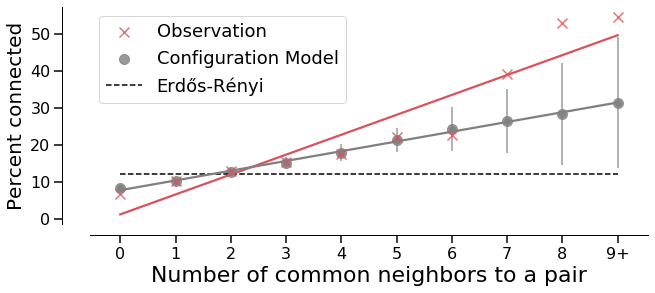

In [13]:
# plot CNR curves
E, N = len(g_th300.edges), len(g_th300.nodes)
ER_p_null = (1 - E / (N*(N-1)))**2

plot_cnr(obs_cnr_stats, cfg_cnr_stats, cfg_cnr_stats_std, ER_p_null, figsize=(10,4), fname="th300/th300_cnr")

In [14]:
# Pearson r^2 and p-value for OBS
pearson_r2(np.arange(10), obs_cnr_stats["undir_perc"])

(0.8782747502794787, 6.319837285888977e-05)

In [15]:
# Pearson r^2 and p-value for CFG
pearson_r2(np.arange(10), cfg_cnr_stats["undir_perc"])

(0.9961770744550158, 5.849336762062495e-11)

### 3. Common Neighbor Rule (OBS vs gER vs gCFG)

In [16]:
%%time
# sample graphs from gCFG model and compute CNR stats
s=100 # total 100 samples (100 continous samples)
cfg_cnr_samples_GE = continuous_sample_cnr_GE(g_th300, samples=s, niters=int(1e4))
cfg_cnr_stats_GE, cfg_cnr_stats_std_GE = cnr_mean_std(cfg_cnr_samples_GE)


CPU times: user 39 s, sys: 76 ms, total: 39.1 s
Wall time: 39 s


In [17]:
# save sampled CNR stats from CFG model as intermediate data
cfg_cnr_stats_GE.to_csv("saved/th300_cnr_gcfg100.csv", index=False)
cfg_cnr_stats_std_GE.to_csv("saved/th300_cnrstd_gcfg100.csv", index=False)

In [18]:
# load precomputed CNR stats counts from CFG model
cfg_cnr_stats_GE = pd.read_csv("saved/th300_cnr_gcfg100.csv")
cfg_cnr_stats_std_GE = pd.read_csv("saved/th300_cnrstd_gcfg100.csv")

In [19]:
cfg_cnr_stats_GE

,undir_pair,dir_spair,dir_ppair,undir_conn,dir_sconn,dir_pconn,dir_uni_sconn,dir_uni_pconn,dir_bi_sconn,dir_bi_pconn,undir_perc,dir_sperc,dir_pperc
0,1232.45,3569.60,3010.49,106.81,375.17,344.95,359.61,328.81,15.56,16.14,0.086674,0.105102,0.114587
1,1512.89,1025.50,1446.15,156.65,144.68,182.19,136.80,173.02,7.88,9.17,0.103534,0.141098,0.126004
2,1073.63,255.02,396.95,133.49,47.46,51.94,44.16,48.91,3.30,3.03,0.124289,0.186226,0.130822
3,601.00,67.49,81.10,90.13,16.19,11.64,14.82,11.08,1.37,0.56,0.149941,0.240065,0.143528
4,294.40,20.40,13.14,52.38,5.68,1.94,5.20,1.86,0.48,0.08,0.177874,0.278733,0.143692
5,132.70,6.94,1.92,27.30,2.26,0.28,2.03,0.26,0.23,0.02,0.205653,0.321231,0.129833
6,57.86,2.66,0.23,13.51,0.81,0.06,0.73,0.06,0.08,0.00,0.232552,0.272952,0.050000
7,25.53,1.34,0.01,7.06,0.38,0.00,0.33,0.00,0.05,0.00,0.272825,0.212500,0.000000
8,11.54,0.59,0.01,3.22,0.22,0.00,0.18,0.00,0.04,0.00,0.287947,0.151667,0.000000
9,8.00,0.46,0.00,2.45,0.15,0.00,0.14,0.00,0.01,0.00,0.281984,0.120000,0.000000


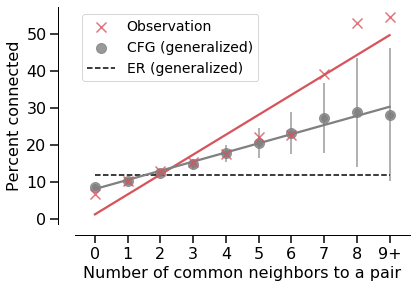

In [20]:
# plot CNR curves
_, two_pr_GE = compute_three_neuron_motif_probabilities_GE(g_th300)
ER_p_null_GE = 1 - 2*two_pr_GE["pr_uni"] - two_pr_GE["pr_bi"]

plot_cnr(obs_cnr_stats, cfg_cnr_stats_GE, cfg_cnr_stats_std_GE, ER_p_null_GE, 
         figsize=(6,4), fontsizes=(16, 16, 16, 14), cfg_name="CFG (generalized)", er_name="ER (generalized)", fname="th300/th300_cnr_GE")

### 4. Generate Small Plots for Panels (OBS vs gER vs CFG)

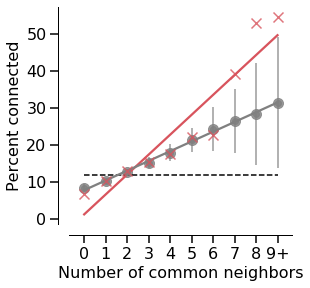

In [21]:
plot_cnr_adapt(obs_cnr_stats, cfg_cnr_stats, cfg_cnr_stats_std, ER_p_null_GE, 
         figsize=(4,4), fontsizes=(16, 16, 16, 14), fname="th300/th300_cnr_CGE")